In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets

mnist = datasets.load_digits()

In [2]:
mnist

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(1797, 64)

In [5]:
y.shape

(1797,)

In [6]:
img = mnist['images']
img.shape

(1797, 8, 8)

We then can conclude we have a dataset with 1797 8 by 8 images. As an example, let us plot one image

In [7]:
print(img[0])

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


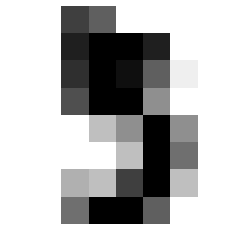

In [8]:
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(img[5], cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

It seem's me that it's the number five. Let's take a look at its target:

In [9]:
y[5]

5

Before we start, let us split the dataset into a tranning and a testing set.

In [10]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, shuffle = True) 

We also have shuffled the data to guarantee that all cross-validation folds will be similar.

In [11]:
X_train.shape

(1437, 64)

# Training a Binary Classifier

In order to simplify the problem, let's trainning a binary classifier able to distinguish only between if the digit is - let's say - '5' or doen't.

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
y_train_5

array([False,  True, False, ..., False, False, False])

## Stochastic Gradient Descent (SGD)

We'll start this classification using Scikit-Learn's SGDClassifier class, which has the advantage of being capable of handling very large datasets efficiently. This is part because SGD delas with training instances indepently.

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

We've the random_state = 42 in order to guarantee reproduciblity. Note that the features of our model are the pixels of the image.

Now we can use this classifier to preditc a digit. Let us see what is its answer to our the digit we've printed before:

In [15]:
sgd_clf.predict([X[5]])

array([ True])

In this case it is not correct, let's now evaluate its performance.

### Performance Measures (pg 83)

#### Cross-Validation

Let us now split the trainning set into K-folds (in this case, three), then making prediction and evaluating them, on each fold using a model trained on the remaining folds.

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.98538622, 0.99373695, 0.9874739 ])

Altough it seems an incredicble accuracy, let us built a model that classify all images as not being 5 and evaluate its score.

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
never_5_clf.fit(X_train,y_train_5)

In [19]:
never_5_clf.predict([X[5]])

array([[False]])

In [20]:
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91022965, 0.89979123, 0.88935282])

Well, well... Since aroud 10% of our targets are number 5 then the accuracy of our never_5_clf must be around 90%.

This examplifies that accuracy is - in general - a bad performance measure for classifiers.

#### Confusion matrix

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train,y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[1283,   10],
       [   6,  138]], dtype=int64)

Let us write explicitly the four terms of the confusion matrix:

TN := True negatives. You predicted negative and it's negative (1280 cases).

FP := False positive. You predicted positive and it’s falses (7 cases).

FN := False negatives. You predicted negative and it's positive (9 cases).

TP := True positive. You predicted positive and it's positive (141 cases).

The NEGATIVE and the POSITIVE refers to our prevision and TRUE or False with it's right or wrong.


Once we have stated these observations of the confusion matrix, we hope that the second column of the never_5_classifier should be zero:

In [22]:
y_train_pred_never_5 = cross_val_predict(never_5_clf, X_train,y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred_never_5)

array([[1293,    0],
       [ 144,    0]], dtype=int64)

Sometimes we will want a concise metric, thus it is convenient to define the precision of the classifier:

\begin{equation}
    precision = \frac{TP}{TP + FP}
\end{equation}

where TP is the true positive and FP is the False positive. There is also another measure that should be taking in account within precision is what is called by reccall (sensitivity or true positive rate):

\begin{equation}
    recall = \frac{TP}{TP+FN}
\end{equation}

where FN is the number of false negatives.

Let us now calculate these both metrics in our classifiers.

In [23]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
recall_score(y_train_5, y_train_pred)

0.9324324324324325


0.9583333333333334

In [24]:
print(precision_score(y_train_5, y_train_pred_never_5))
recall_score(y_train_5, y_train_pred_never_5)

0.0


C:\Users\william.malouf\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

It is also convenient to combine precision and recall in a single measure so we can better compare different models. One way to do it is to make an harmonic mean, that is

\begin{equation}
F_1 = \frac{2}{\frac{1}{precision} +\frac{1}{recall}}
\end{equation}

which is the so called $F_1$ score. The 2 in the numerator is to guarantee the normalization. We make an harmonic mean to guarantee that $F_1$ only will be high if precision and recall were high.

In [25]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred_never_5))

0.9452054794520548
0.0


#### Precision/recall Tradeoff

For each instance, the model computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class. Thus, as we increase the threshod we increase Precision but deacrease Recall. 

In [28]:
y_scores = sgd_clf.decision_function([X[5]])
print(y_scores)

[41.82475735]


The SGDClassifier uses a threshold equal to 0 and Scikit-Learn does not allow us to modify it manually. We then can built another predictor:

In [29]:
threshold = 100
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In order to decide what threshod we shall use, let us study its behavior as a function of the Precision and Recall.

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

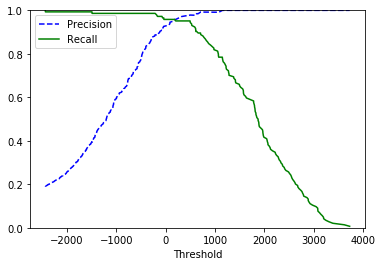

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

The choice of the Threshold will depended of the problem in question and we also can plot a curve of the Precision vs Recall to define it. (pg. 90)

#### The ROC Curve

In the Receiver Operating Characteristic (ROC) curve we plot the true positive rate - TPR - (another name for recall) against the false positive rate - FPR.

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

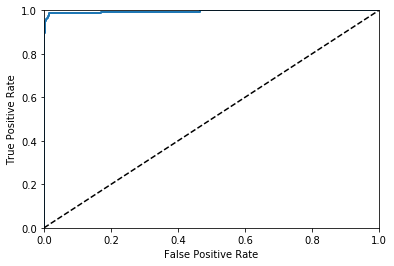

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

Note that the dotted line is a random classifier, that is, our classifier will be as good as it stays away from that line (toward the top left corner).

If it is necessary one measure to compare the classifier it to measure the Area Under the Curve (AUC). While a perfect classifier will have an AUC curve equal to one a pure random will have an AUU equal to 0.5.

In [35]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9950212683681361